
# Setup of the environment

First, we are setting up our environment. We use an already compiled and packaged installation of HOOMD-blue and the DLExt plugin. We copy it from Google Drive and install pysages for it. This may require you to have read permissions to the shared Google Drive. We also have a Google Colab that performs this installation for reference.


In [1]:
%%bash

BASE_URL="https://drive.google.com/u/0/uc?id=1hsKkKtdxZTVfHKgqVF6qV2e-4SShmhr7&export=download"
wget -q --load-cookies /tmp/cookies.txt "$BASE_URL&confirm=$(wget -q --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate $BASE_URL -O- | sed -rn 's/.*confirm=(\w+).*/\1\n/p')" -O pysages-env.zip
rm -rf /tmp/cookies.txt

In [2]:
%env PYSAGES_ENV=/env/pysages

env: PYSAGES_ENV=/env/pysages


In [3]:
%%bash

mkdir -p $PYSAGES_ENV
unzip -qquo pysages-env.zip -d $PYSAGES_ENV
rm pysages-env.zip

In [4]:
import os
import sys

ver = sys.version_info

sys.path.append(os.environ["PYSAGES_ENV"] + "/lib/python" + str(ver.major) + "." + str(ver.minor) + "/site-packages/")

## PySAGES

The next step is to install PySAGES.
First, we install the jaxlib version that matches the CUDA installation of this Colab setup. See the JAX documentation [here](https://github.com/google/jax) for more details.

In [5]:
%%bash

pip install -q --upgrade pip &> /dev/null
# Installs the wheel compatible with CUDA 11 and cuDNN 8.2 or newer.
pip install -q --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html &> /dev/null

We test the jax installation and check the versions.

In [6]:
import jax
import jaxlib
print(jax.__version__)
print(jaxlib.__version__)

0.2.27
0.1.75


Now we can finally install PySAGES. We clone the newest version from [here](https://github.com/SSAGESLabs/PySAGES) and build the remaining pure python dependencies and PySAGES itself.

In [7]:
%%bash

rm -rf PySAGES
git clone https://github.com/SSAGESLabs/PySAGES.git &> /dev/null
cd PySAGES
pip install -q . &> /dev/null

# Harmonic Bias simulation

A harmonic bias simulation constraints a collective variable with a harmonic potential. This is useful for a variety of advanced sampling methods, in particular, umbrella sampling.

For this Colab, we are generating a small system of soft DPD particles first. This system of soft particles allows fast reliable execution.
For this, we use the [GSD](https://gsd.readthedocs.io/en/stable/) file format and its python frontend to generate the initial conditions.
Since all particles are soft, it is OK to start with random positions inside the simulation box. We also assign random velocities drawn from the Maxwell-Boltzmann distribution. The final configuration is written to disk and can be opened by HOOMD-blue for simulations.

In [8]:
!pip install -q gsd &> /dev/null

import sys
import numpy as np
import gsd
import gsd.hoomd


class System:
    def __init__(self):
        self.L = 5
        self.N = 200


def post_process_pos(snapshot):
    box_size = snapshot.configuration.box[:3]
    snapshot.particles.image = np.rint(snapshot.particles.position / box_size)
    snapshot.particles.position -= snapshot.particles.image * box_size
    return snapshot


def get_snap(system):
    L = system.L
    snapshot = gsd.hoomd.Snapshot()
    snapshot.configuration.box = [L, L, L, 0, 0, 0]

    snapshot.particles.N = N = system.N

    snapshot.particles.types = ["A"]
    snapshot.particles.position = np.zeros((N, 3))
    snapshot.particles.velocity = np.random.standard_normal((N, 3))
    snapshot.particles.image = np.zeros((N, 3), dtype=int)
    snapshot.particles.typeid = np.zeros(N, dtype=int)

    rng = np.random.default_rng()
    for particle in range(N):
        snapshot.particles.position[particle, 0] = (rng.random() * L - L / 2)
        snapshot.particles.position[particle, 1] = (rng.random() * L - L / 2)
        snapshot.particles.position[particle, 2] = (rng.random() * L - L / 2)

    return snapshot

system = System()
snap = get_snap(system)
snap = post_process_pos(snap)
snap.particles.validate()
with gsd.hoomd.open("harmonic_start.gsd", "wb") as f:
   f.append(snap)


Next, we start running the system, we start with importing the required libraries.
Noteworthy are here the hoomd package with the MD and dlext module, and the pysages objects.
We are going to use a collective variable that constrains a particle position. In PySAGES the `Component` class from the `colvars` package can achieve this for us.
The `HarmonicBias` class is responsible for introducing the bias into the simulation run, while `HistogramLogger` collects the state of the collective variable during the run.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import hoomd
import hoomd.md
import hoomd.dlext

import pysages
from pysages.colvars import Component
from pysages.methods import HarmonicBias, HistogramLogger

The next step is to write a function that generates the simulation context.
Inside this function is the HOOMD-blue specific code, that you would normally write to execute a HOOMD-blue simulation. Here it is packaged into a function, such that PySAGES can deploy the simulation context when needed.
In this case, we use the GSD file read in the initial, and define the DPD forcefield with parameters.
DPD is a special case in HOOMD-blue. The thermostat is part of the pair-potential and not part of the integrator. Hence, we specify NVE integration and all thermostat parameter for NVT in the potential. The function returns the simulation context for PySAGES to work with.

The second function is a helper function to generate the theoretically expected distribution of a harmonically biased simulation of an ideal gas in NVT. And helps to verify the results of the simulation.

In [10]:
"""
Generates a simulation context, we pass this function to the attribute `run` of our sampling method.
"""
def generate_context(**kwargs):
    hoomd.context.initialize('')
    context = hoomd.context.SimulationContext()
    with context:
        hoomd.init.read_gsd("harmonic_start.gsd")
        hoomd.md.integrate.nve(group=hoomd.group.all())
        hoomd.md.integrate.mode_standard(dt=0.01)

        nl = hoomd.md.nlist.cell()
        dpd = hoomd.md.pair.dpd(r_cut=1, nlist=nl, seed=42, kT=1.0)
        dpd.pair_coeff.set(
            "A", "A", A=kwargs.get("A", 5.0), gamma=kwargs.get("gamma", 1.0)
        )
    return context

def get_target_dist(center, k, lim, bins):
    x = np.linspace(lim[0], lim[1], bins)
    p = np.exp(-0.5 * k * (x - center)**2)
    # norm numerically
    p *= (lim[1] - lim[0]) / np.sum(p)
    return p


The next step is to define the collective variables (CVs) we are interested in.
In this case, we are using the `Component` CV to describe the position in space. We choose particle `[0]` for this and log in 3 different CVS the Z- `2`, Y- `1`, and X- `0` position of the particle.
The center describes where we are restraining the CVs to, which is also specified for each of the CVs described earlier.

Finally, we define the spring constant for the harmonic biasing potential and the `HarmonicBias` method itself.

In [11]:
cvs = [Component([0], 2)]
cvs += [Component([0], 1)]
cvs += [Component([0], 0)]

center_cv = [0.0]
center_cv += [1.0, -0.3]

k = 15
method = HarmonicBias(cvs, k, center_cv)


Next, we define the `HistogramLogger` callback. The callback interacts with the simulation every timestep after the biasing. In this case, we use it to log the state of the collective variables every `100` time-steps.

And we can finally run the simulations. This happens through the PySAGES method run and is transparent to the user which backend is running.
Here, the run is just a simple simulation for the number of steps specified with the biasing potential. Other advanced sampling methods can have more advanced run schemes.

In [12]:
callback = HistogramLogger(100)
pysages.run(method, generate_context, int(1e4), callback, {"A": 7.0}, profile=True)

HOOMD-blue v2.9.7 CUDA (11.1) DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 01/26/2022
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
no CUDA-capable device is detected
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 200 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 200
notice(2): Neighbors included by diameter          : no
notice

After the simulation run, we collect the results for comparison with the analytic prediction for an ideal gas.
First, we generate the analytic predictions for each of the CVs in a list `target_hist`.

After that, we are using the collected results from the callback to build the histograms from the simulations, and store the results in `hist_list`.

In [13]:
Lmax = 5.0
bins = 25
target_hist = []
for i in range(len(center_cv)):
    target_hist.append(
        get_target_dist(center_cv[i], k, (-Lmax / 2, Lmax / 2), bins)
    )
lims = [(-Lmax / 2, Lmax / 2) for i in range(3)]
hist, edges = callback.get_histograms(bins=bins, range=lims)
hist_list = [
    np.sum(hist, axis=(1, 2)) / (Lmax ** 2),
    np.sum(hist, axis=(0, 2)) / (Lmax ** 2),
    np.sum(hist, axis=(0, 1)) / (Lmax ** 2),
]
lim = (-Lmax / 2, Lmax / 2)

Finally, we want to evaluate how the simulations turned out.
We use matplotlib to visualize the expected (dashed) and actual results of the simulations (solid).

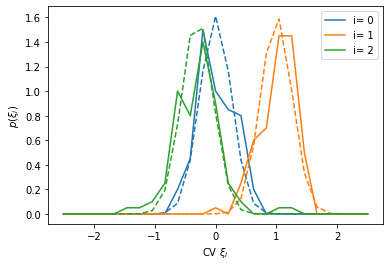

In [14]:
fig, ax = plt.subplots()

ax.set_xlabel(r"CV $\xi_i$")
ax.set_ylabel(r"$p(\xi_i)$")

x = np.linspace(lim[0], lim[1], hist_list[0].shape[0])

for i in range(len(hist_list)):
    (line,) = ax.plot(x, hist_list[i], label="i= {0}".format(i))
    ax.plot(x, target_hist[i], "--", color=line.get_color())

ax.legend(loc="best")


We can see, that the particle positions are indeed centered around the constraints we set up earlier. Also, we see the shape of the histograms is very similar to the expected analytical prediction. We expect this since a liquid of soft particles is not that much different from an ideal gas.